# Physical Activity Monitoring Report
---

# Table of contents
1. [Introduction](#introduction)
2. [Data Cleaning and Filtering](#cleaning)
3. [Downsampling](#downsampling)
4. [Development and Test Set](#devandtest)
5. [Exploratory Data Analysis](#eda)
6. [Hypothesis Testing](#hyp)
7. [Principle Component Analysis](#PCA)
8. [Clustering](#clustering)
9. [Logistical Regression](#logreg)
10. [Recommendations and Summary](#recs)

---
## 1. Introduction <a name="introduction"></a>
This report will analyse the data provided by UCI Machine Learning Reposity on Physical Activity Monitoring Data Set.
The data provided is from 9 participants, 8 males and 1 female. Each participant engaged in several activities while wearing a heart rate monitor (sampling frequency ~9Hz) and three Colibri wireless inertial measuring units (sampling frequency 100Hz), on their chest, hand and ankle.


In this report I will make recommendations on how to develop software or hardware to:
- Determine the **amount** of physical activity performed, this can be done in two ways; heart rate or duration. I will focus on heart rate in my report.
- Determine the **type** of activity performed
---
### Overview of specific requirements
- **Data cleaning and Exploratory Data Analysis**

I will first clean my data by removing columns that are noted in the 'readme' file to not be accurate. Therefore I will delete the 6g accelerometer data and orientation data. I will also remove all of the rows where the activityID is 0 since we only want to analyse data that has a specific activity related to it.

I will focus mainly on grouping the data by activity for my exploratory data analysis so that I can work on developing recommendations to find the type of activity based on the data. I will look at:
- the comparison between each activity and their mean heart rate
- the comparison between each activity and their gyroscope data
- the comparison between each activity and their mean temperature across their chest, hand and ankle


---
- **Hypothesis Testing**

I will run three hypothesis tests based on my Exploratory Data Analysis:

>**If** higher intensity activities are related to heart rate, **then** when intensive activities are performed heart rate will be higher than those who are performing lower intensity activities.

If this test is shown to be statistically accurate then I could recommend that increased heart rate suggests the user is exercising.

>**If** stair ascending or descending activities are related to latitude change, **then** when stair activities are performed chest gyroscope 2 will have a higher absolute mean value.

If this test is shown to be statistically accurate then I could recommend that a significant increase or decrease in latitude based on gyroscope data would mean that the user is climbing or descending stairs.

>**If** high temperature is related to high intensity activities **then** when intensive activities are performed mean temperature will be higher than those who are performing lower intensity activities.

If this test is shown to be statistically accurate the I could recommend that increased temperature suggests the user is exercising.

---
- **Develop and testing cluster modeling**

I will be creating a cluster model for my data that will create groups for the data.
??? WRITE MORE HERE


---
<div class="alert alert-block alert-info">
<b>Note:</b> For the rest of the report text sections will directly refer to the code below. </div>

Imports for use in the rest of our report.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt 
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import cluster
from sklearn.cluster import KMeans 
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler,RobustScaler
from scipy import stats
from collections import defaultdict
import random
from numpy.random import RandomState

Reading all 14 of our files to prepare them for being combined into a dataframe.

In [2]:
df1 = pd.read_csv("subject101.dat", header=None, delim_whitespace=True)
df2 = pd.read_csv("subject101op.dat", header=None, delim_whitespace=True)
df3 = pd.read_csv("subject102.dat", header=None, delim_whitespace=True)
df4 = pd.read_csv("subject103.dat", header=None, delim_whitespace=True)
df5 = pd.read_csv("subject104.dat", header=None, delim_whitespace=True)
df6 = pd.read_csv("subject105.dat", header=None, delim_whitespace=True)
df7 = pd.read_csv("subject105op.dat", header=None, delim_whitespace=True)
df8 = pd.read_csv("subject106.dat", header=None, delim_whitespace=True)
df9 = pd.read_csv("subject106op.dat", header=None, delim_whitespace=True)
df10 = pd.read_csv("subject107.dat", header=None, delim_whitespace=True)
df11 = pd.read_csv("subject108.dat", header=None, delim_whitespace=True)
df12 = pd.read_csv("subject108op.dat", header=None, delim_whitespace=True)
df13 = pd.read_csv("subject109.dat", header=None, delim_whitespace=True)
df14 = pd.read_csv("subject109op.dat", header=None, delim_whitespace=True)

Naming all of our columns so that it is clearer when analysing our data, this list will be used later in our data. I have also created a dictionary for the activityID's

In [3]:
headings = ['Timestamp', 
    'ActivityID',
    'Heartrate',
    'IMU_Hand_Temp',
    'IMU_Hand_3D_acceleration_1',
    'IMU_Hand_3D_acceleration_2', 
    'IMU_Hand_3D_acceleration_3',
    '1','2','3',
    'IMU_Hand_3D_gyroscope_1',
    'IMU_Hand_3D_gyroscope_2', 
    'IMU_Hand_3D_gyroscope_3', 
    'IMU_Hand_3D_magnetometer_1',
    'IMU_Hand_3D_magnetometer_2',
    'IMU_Hand_3D_magnetometer_3',
    '4','5','6','7',
    'IMU_Chest_Temp', 
    'IMU_Chest_3D_acceleration_1',
    'IMU_Chest_3D_acceleration_2',
    'IMU_Chest_3D_acceleration_3',
    '8','9','10',
    'IMU_Chest_3D_gyroscope_1',
    'IMU_Chest_3D_gyroscope_2',
    'IMU_Chest_3D_gyroscope_3',
    'IMU_Chest_3D_magnetometer_1',
    'IMU_Chest_3D_magnetometer_2',
    'IMU_Chest_3D_magnetometer_3',
    '11','12','13','14',
    'IMU_Ankle_Temp',
    'IMU_Ankle_3D_acceleration_1',
    'IMU_Ankle_3D_acceleration_2',
    'IMU_Ankle_3D_acceleration_3',
    '15','16','17',        
    'IMU_Ankle_3D_gyroscope_1',
    'IMU_Ankle_3D_gyroscope_2',
    'IMU_Ankle_3D_gyroscope_3', 
    'IMU_Ankle_3D_magnetometer_1',
    'IMU_Ankle_3D_magnetometer_2',
    'IMU_Ankle_3D_magnetometer_3',
    '18','19','20','21']

Activities = {1:"lying",2:"sitting",3:"standing",4:"walking",5:"running",6:"cycling",7:"Nordic walking",
              9:"watching TV",10:"computer work",11:"car driving",12:"ascending stairs",13:"descending stairs",
              16:"vacuum cleaning",17:"ironing",18:"folding laundry",19:"house cleaning",20:"playing soccer",
              24:"rope jumping"}

Combing all our data frames into one and adding a 'subjects' column so that we can still differentiate between the subjects when necessary. 

Also filling in the NaN values in the heart rate column using fillna with forward fill.

In [4]:
#list of all the data frames and list of all the subject names to be added into the new column
mylist = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14] 
subject_names = ['101','101op','102','103','104','105','105op','106','106op','107','108','108op','109','109op']
subjects = [] #creating an empty list of subjects that will have all of the dataframes added to it

x=0
#looping through the dataframes
for i in mylist:  
    i.columns=headings #adding the headings to the data frames
    i['Heartrate'] = i['Heartrate'].fillna(method='ffill') #forward filling all NaN heartrate values
    i['subject']=subject_names[x] #adding subject column
    subjects.append(i) #add the dataframe to subjects list for concatenation later
    x+=1 #increment x

df = pd.concat(subjects) #combining all the data frames 
df.shape

(3850505, 55)

---
## 2. Data Cleaning and Filtering <a name="cleaning"></a>
Firstly we are **removing any rows where the activity number is 0** as this not a specific activity and we cannot analyse it. 

Then we are **removing all the 6g acceleration columns** as they were not precisely calibrated so we will use the 16g acceleration data instead.

We are also **removing all orientation columns** as the data was invalid.

Some of the activities were optional which lead to less participants such as car driving and watching TV that only have one participant and playing soccer only has two. For that reason I will also be **removing all of the optional activities**.

In [5]:
df = df[df.ActivityID != 0] #removing rows where ActivityID = 0
df = df.drop(df.columns[[7,8,9, 
                        16,17,18,19,
                        24,25,26,
                        33,34,35,36,
                        41,42,43,
                        50,51,52,53]], axis = 1) #removing 6g acceleration data and orientation from all IMU data
df = df[~df.subject.str.contains("op")] #removing all of the optional activity dataframes

Shape before removing NaN values.

In [6]:
df.shape

(1942872, 34)

In [7]:
df=df.dropna()

We can see we removed 21,441 NaN rows.

In [8]:
df.shape

(1921431, 34)

Using the activity dictionary to create a new column "Activity" that has the activity names.

In [9]:
df['Activity'] = df['ActivityID'].map(Activities)

If you scroll to the far right you can now see the 'Activity' column which will make all of our analysis a lot clearer and easier to read as we will not have to check which activity the activityID would be refering to.

In [10]:
df.head()

,Timestamp,ActivityID,Heartrate,IMU_Hand_Temp,IMU_Hand_3D_acceleration_1,IMU_Hand_3D_acceleration_2,IMU_Hand_3D_acceleration_3,IMU_Hand_3D_gyroscope_1,IMU_Hand_3D_gyroscope_2,IMU_Hand_3D_gyroscope_3,...,IMU_Ankle_3D_acceleration_2,IMU_Ankle_3D_acceleration_3,IMU_Ankle_3D_gyroscope_1,IMU_Ankle_3D_gyroscope_2,IMU_Ankle_3D_gyroscope_3,IMU_Ankle_3D_magnetometer_1,IMU_Ankle_3D_magnetometer_2,IMU_Ankle_3D_magnetometer_3,subject,Activity
2928,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,101,lying
2929,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,101,lying
2930,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,101,lying
2931,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,101,lying
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,101,lying


---
## 3. Downsampling <a name="downsampling"></a>

Our data cycle is currently measured every 10 milliseconds or every 0.01 seconds. This means our data has a frequency of 100Hz. We currently have nearly 2 million data points in our data frame which can make analysis very slow so downsampling will speed up this process. We will round our time stamp data to every 100 milliseconds of every 0.1 seconds, which will mean our data will have a frequency of 10Hz which is much more manageable - we will also take the average of all of the data points within that 0.1 seconds so we are still maintainging the data as much as possible.

In [11]:
df.head()

,Timestamp,ActivityID,Heartrate,IMU_Hand_Temp,IMU_Hand_3D_acceleration_1,IMU_Hand_3D_acceleration_2,IMU_Hand_3D_acceleration_3,IMU_Hand_3D_gyroscope_1,IMU_Hand_3D_gyroscope_2,IMU_Hand_3D_gyroscope_3,...,IMU_Ankle_3D_acceleration_2,IMU_Ankle_3D_acceleration_3,IMU_Ankle_3D_gyroscope_1,IMU_Ankle_3D_gyroscope_2,IMU_Ankle_3D_gyroscope_3,IMU_Ankle_3D_magnetometer_1,IMU_Ankle_3D_magnetometer_2,IMU_Ankle_3D_magnetometer_3,subject,Activity
2928,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,101,lying
2929,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,101,lying
2930,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,101,lying
2931,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,101,lying
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,101,lying


We need to group by the new 'DStime' but also by 'subject' and 'Activity' as otherwise it would combine time stamps from other subjects together. When we groupby we are using the mean() function so that it will average out all of our other variables in our data.

In [12]:
df['DStime'] = df.Timestamp.round(1) #round timestamp column to 1 decimal place
df=df.groupby(['DStime','subject','Activity'], as_index=False).mean() #grouping by DStime, subject and Activity

We now have just under 200,000 data points which should still give us a great amount of accuracy but will decrease our run times, especially for cluster analysis.

In [13]:
df['ActivityID'] = df['ActivityID'].astype(int) #removing the .0 added on from the rounding

In [14]:
df.shape

(194335, 36)

In [15]:
df.head()

,DStime,subject,Activity,Timestamp,ActivityID,Heartrate,IMU_Hand_Temp,IMU_Hand_3D_acceleration_1,IMU_Hand_3D_acceleration_2,IMU_Hand_3D_acceleration_3,...,IMU_Ankle_Temp,IMU_Ankle_3D_acceleration_1,IMU_Ankle_3D_acceleration_2,IMU_Ankle_3D_acceleration_3,IMU_Ankle_3D_gyroscope_1,IMU_Ankle_3D_gyroscope_2,IMU_Ankle_3D_gyroscope_3,IMU_Ankle_3D_magnetometer_1,IMU_Ankle_3D_magnetometer_2,IMU_Ankle_3D_magnetometer_3
0,31.2,109,rope jumping,31.225,24,139.0,24.875000,-9.063530,3.647015,1.707348,...,31.3125,5.701503,-1.033419,-2.761903,-0.040953,0.020846,0.438237,-41.996317,-15.532933,4.753453
1,31.3,109,rope jumping,31.300,24,139.0,24.875000,-7.688702,3.062061,2.322193,...,31.3125,8.703349,-0.863011,-2.421318,1.014848,0.274131,1.586576,-43.457756,-11.848357,4.641602
2,31.4,109,rope jumping,31.400,24,139.0,24.875000,-8.074721,2.548240,2.937051,...,31.3125,11.980173,2.083461,-2.432118,-0.605898,0.272718,0.748527,-45.028336,-6.639915,3.694515
3,31.5,109,rope jumping,31.500,24,139.0,24.881944,-9.123870,1.337881,3.893047,...,31.3125,9.286288,-1.233983,-2.901838,-0.199494,0.003213,0.043435,-45.200356,-4.915288,2.626022
4,31.6,109,rope jumping,31.600,24,139.0,24.937500,-9.360793,3.157591,2.065512,...,31.3125,9.604828,-0.954374,-2.255197,0.099069,-0.013987,-0.053509,-45.073918,-5.025527,2.660976


---
## 4. Development and Test Set <a name="devandtest"></a>



We need to create two random sets; a development set and a test set. We do this to **prevent p-hacking**, which is a way to manipulate the data by running enough tests that eventually you will get a desired result. So by having my preliminary investigations on only half of my data, I can prevent this. I have also set a random seed so that if I ever run the function again it will start at the same point so I can maintain the same dev and test set. I have made it so that 80% of my data is in the development set and 20% in my test set.

In [16]:
df=df.reset_index(drop=True) #the index needs resetting as multiple data frames have been combined and NaNs dropped

random.seed(25) #seed set so that it will maintain dev and test set with each run

dfd=df.sample(frac=0.8, random_state=25) #80% of data in dev set
testdf=df.loc[~df.index.isin(dfd.index)] #test set is everything in the main df that is not in the dev set
dfd.head()

,DStime,subject,Activity,Timestamp,ActivityID,Heartrate,IMU_Hand_Temp,IMU_Hand_3D_acceleration_1,IMU_Hand_3D_acceleration_2,IMU_Hand_3D_acceleration_3,...,IMU_Ankle_Temp,IMU_Ankle_3D_acceleration_1,IMU_Ankle_3D_acceleration_2,IMU_Ankle_3D_acceleration_3,IMU_Ankle_3D_gyroscope_1,IMU_Ankle_3D_gyroscope_2,IMU_Ankle_3D_gyroscope_3,IMU_Ankle_3D_magnetometer_1,IMU_Ankle_3D_magnetometer_2,IMU_Ankle_3D_magnetometer_3
25199,445.2,107,sitting,445.2,2,65.0,31.6875,-1.893938,6.389924,7.096335,...,31.3750,9.243365,-1.292796,-3.653045,0.012949,-0.014444,0.004982,-5.085044,-7.180874,11.649327
65155,971.1,104,ironing,971.1,17,107.0,33.5000,-5.514400,-0.677807,7.460542,...,34.1875,10.113889,0.354044,-0.133332,0.027062,0.509818,0.207555,-38.865856,-4.177464,39.760167
93827,1419.2,103,vacuum cleaning,1419.2,16,93.0,33.1875,-8.890388,6.592283,0.465493,...,34.1250,10.975393,0.669437,-1.377694,0.350003,-0.589926,0.397779,-40.148136,-18.926018,25.628555
116699,1972.8,108,ascending stairs,1972.8,12,167.0,33.9375,-10.456847,-2.245722,-1.001173,...,33.8750,10.338493,-0.308871,-3.247993,-0.405577,0.494950,1.144147,-36.844091,7.042577,23.164218
174788,3250.8,102,Nordic walking,3250.8,7,116.0,30.6250,2.327180,14.215085,3.728783,...,34.2500,19.025660,1.333214,4.180466,0.148249,0.333343,-2.522402,-23.170327,33.194700,23.840127


In [17]:
dfd.shape

(155468, 36)

In [18]:
testdf.shape

(38867, 36)

---
## 5. Exploratory Data Analysis <a name="eda"></a>

Our analysis will focus particularly on heart rate as that is one of the key values to work out how much exercise an individual has done and what kind.

### 5.1 Heart rate analysis
This is a bar chart of the mean heart rate for each individual activity. We can see that 'playing soccer' has the highest average heart rate all the way down to 'lying' with the lowest. This would seem to suggest that more intense activities lead to a greater heart rate, this will be tested later through our hypothesis testing.

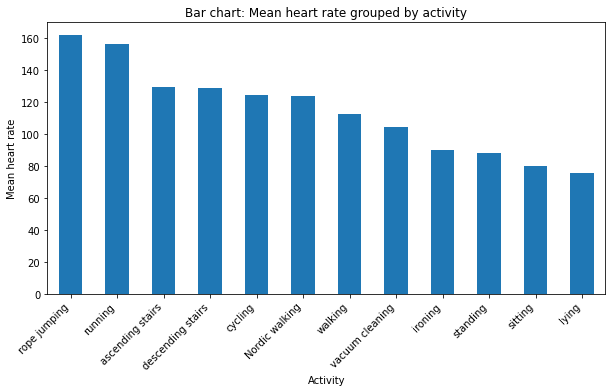

In [19]:
df_hr = dfd['Heartrate'].groupby(dfd['Activity']).mean() #new dataframe grouped by activity for average heartrate
df_hr = df_hr.sort_values(ascending=False) #sort data in descending order
plt.figure(figsize=(10,5)) #make the plot larger
plt.title('Bar chart: Mean heart rate grouped by activity')
plt.ylabel('Mean heart rate')
df_hr.plot(kind='bar') #make the plot a bar chart
plt.xticks(rotation=45, ha='right'); #tilt the x lables so they are easier to read

In [20]:
dfd['Heartrate'].mean()

107.53473948936247

We have now created a box plot of the heart rates for all of the activities, along with a red line across that shows the mean heart rate across all of the data. As expected the more sedentary activities lie below the line such as 'standing', 'ironing' and 'sitting'. Furthermore, an average resting heart rate is between 60-100 bpm and our mean heart rate is 107, therefore the red line is also closely indicative of the maximum likely resting heart rate.

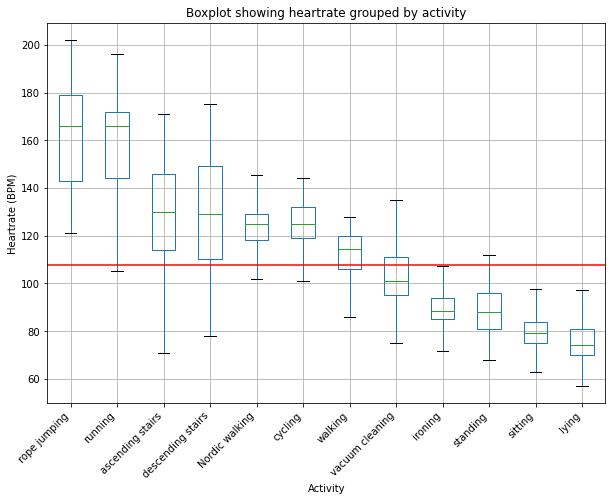

In [21]:
def boxplot_sorted(df, by, column, rot=0):
    # use a dictionary to make new dataframe from the groupby object
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)}) # each group name becomes a column in the new dataframe
    meds = df2.median().sort_values(ascending=False) # find and sort the median values in this new dataframe
    return df2[meds.index].boxplot(rot=rot, return_type="axes",showfliers=False) # return axes 

df_hr2=dfd[['Heartrate','Activity']] #dataframe only containing heart rate and activity
plt.figure(figsize=(10,7)) #make plot bigger
axes = boxplot_sorted(df_hr2, by = ['Activity'], column = 'Heartrate') #using function to sort boxplots in order of median
plt.xlabel('Activity')
plt.ylabel('Heartrate (BPM)')
plt.title('Boxplot showing heartrate grouped by activity')
plt.xticks(rotation=45, ha='right') #tilt the x lables so they are easier to read
plt.axhline(dfd['Heartrate'].mean(), c='r') #put in red line for mean heartrate across the whole data frame
plt.show()

### 5.2 Stair Analysis
In the bar chart, we can see that ascending and descending stairs stand out on this graph of our chest gyroscope data 2. This could be connected to the increase and decrease in latitude whilst using stairs, this will also be tested by one our hypotheses.

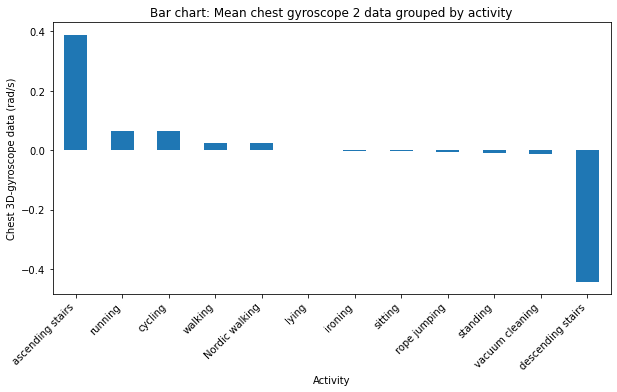

In [22]:
df_cg = dfd['IMU_Chest_3D_gyroscope_2'].groupby(dfd['Activity']).mean() #new data frame grouped by activity sorted for mean chest gyroscope
df_cg = df_cg.sort_values(ascending=False) #sort values in descending order
plt.figure(figsize=(10,5)) #make plot bigger
plt.title('Bar chart: Mean chest gyroscope 2 data grouped by activity')
plt.ylabel('Chest 3D-gyroscope data (rad/s)')
df_cg.plot(kind='bar')
plt.xticks(rotation=45, ha='right'); #tilt the x lables so they are easier to read 

### 5.3 Temperature Analysis
This bar chart uses the temperature from across participants hands, chests and ankles - grouped by the activity. The bar chart is sorted by the mean temperature of the participants chests as this will give us the most accurate reading of their body temperature rather than their surroundings. There does not seem to be any clear correlation between high intensity activities and temperature, but we will test this to make sure in our hypotheses.

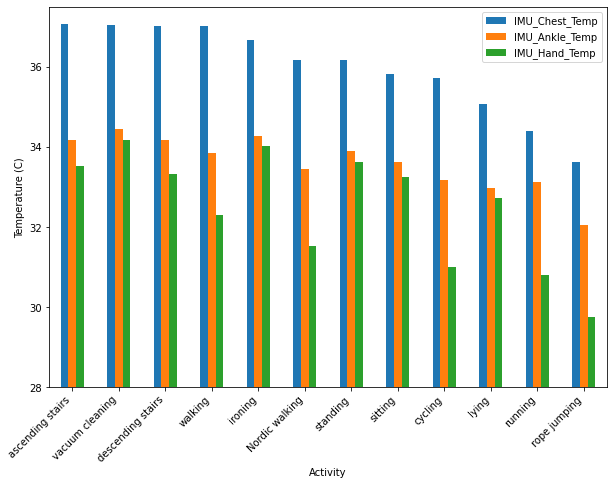

In [23]:
#new data frame grouped by activity sorted by temperature
df_hr = dfd[['IMU_Chest_Temp','IMU_Ankle_Temp','IMU_Hand_Temp']].groupby(dfd['Activity']).mean()
df_hr = df_hr.sort_values(by = 'IMU_Chest_Temp',ascending=False) #sorting by mean chest temp, descending order
df_hr.plot(kind='bar',figsize=(10,7)) #bar chart, and making it bigger
plt.ylabel('Temperature (C)')
plt.ylim(28,37.5) #focusing in on the graph by limiting the y range
plt.xticks(rotation=45, ha='right') #tilt the x lables so they are easier to read 
plt.show;

### 5.4 Variable Correlation Analysis
Below is a correlation heat-map that shows how closely related two parameters are, or not. Dark green suggests a strong correlation all the way down to dark pink, where lighter colours of pink and green suggest minimal correlation. For the most part the graph is quite light in colour which suggest that most of our parameters are not strongly correlated, However, a few do correlate such as chest and hand temperature, along with all the other temperature pairings. Inversely correlated are all of the hand magnetometer parameters and their respective hand acceleration data.

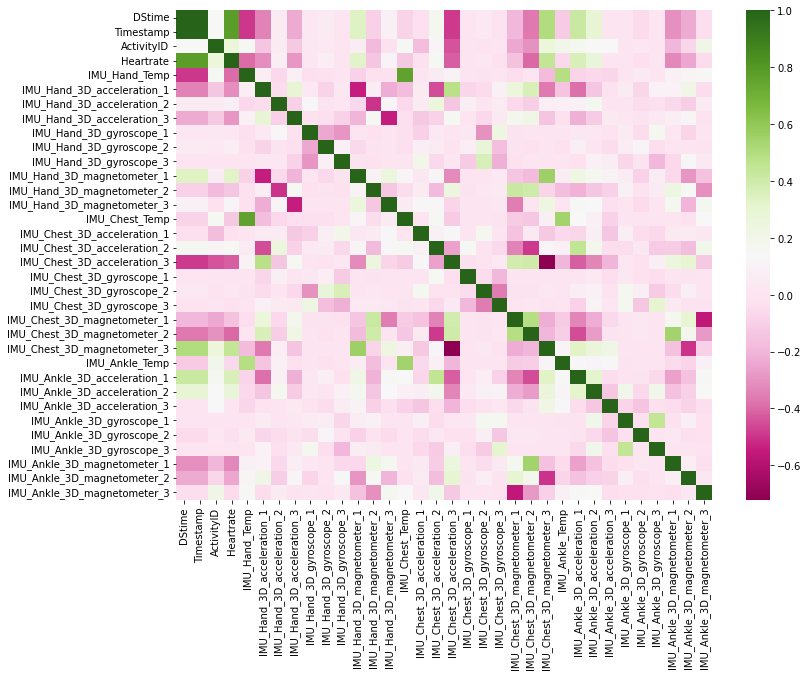

In [24]:
df_heatmap = dfd.corr() #using the corr() function to create heatmap
figure, ax = plt.subplots(figsize=(12, 9)) #making the plot bigger
#seaborn heatmap function, colour map is pink to green 
sns.heatmap(df_heatmap, mask=np.zeros_like(df_heatmap), cmap = "PiYG",ax=ax) 
plt.show()

---
## 6. Hypothesis Testing <a name="hyp"></a>

### 6.1 Heart rate hypothesis test
**If** higher intensity activities are related to heart rate, **then** when intensive activities are performed heart rate will be higher than those who are performing lower intensity activities.

Important to note that "intensive activity" is a subjective statement so other data scientists may disagree with my definition and group separation but within the means of this report I cannot separately access which activity is deemed intensive. However, based on my development data I will create the following two groups:

Higher intensity activities:
- Rope Jumping
- Running
- Ascending Stairs
- Descending Stairs
- Cycling
- Nordic Walking
- Walking

Lower intensity activities:
- Vacuum cleaning
- Ironing
- Standing
- Sitting
- Lying



$μ_1$ = Mean heart rate for 'higher intensity activities'

$μ_2$ = Mean heart rate for 'lower intensity activities'

**Null hypothesis:** higher intensity mean heart rate minus lower intensity mean heart rate is zero

>$H_0:μ_1-μ_2 = 0$ 

**Testable hypothesis:** higher intensity mean heart rate minus lower intensity mean heart rate is more than zero

>$H_1:μ_1-μ_2 > 0$ 

In [25]:
#creating the high intensity activity only data frame
highintensity = testdf.loc[(testdf.Activity=='rope jumping')|
                          (testdf.Activity=='running')|
                          (testdf.Activity=='ascending stairs')|
                          (testdf.Activity=='descending stairs')|
                          (testdf.Activity=='cycling')|
                          (testdf.Activity=='Nordic Walking')|
                          (testdf.Activity=='Walking')]

#creating the low intensity activity only data frame
lowintensity = testdf.loc[(testdf.Activity=='vacuum cleaning')|
                          (testdf.Activity=='ironing')|
                          (testdf.Activity=='standing')|
                          (testdf.Activity=='sitting')|
                          (testdf.Activity=='lying')]

print('Mean heartrate for higher intensity activities: ' + str(highintensity.Heartrate.mean()))
print('Mean heartrate for lower intensity activities: '+ str(lowintensity.Heartrate.mean()))

Mean heartrate for higher intensity activities: 135.87366956792212
Mean heartrate for lower intensity activities: 87.49311653100477


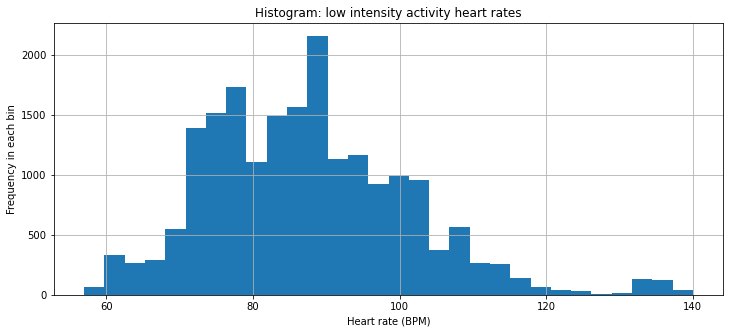

In [26]:
lowintensity.hist(column='Heartrate', figsize=(12,5), bins=30)
plt.title('Histogram: low intensity activity heart rates')
plt.xlabel('Heart rate (BPM)')
plt.ylabel('Frequency in each bin');

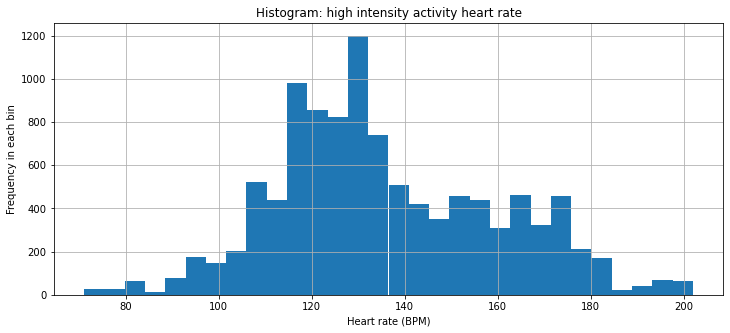

In [27]:
highintensity.hist(column='Heartrate', figsize=(12,5), bins=30)
plt.title('Histogram: high intensity activity heart rate')
plt.xlabel('Heart rate (BPM)')
plt.ylabel('Frequency in each bin');

In [28]:
#Calculating the mean, standard deviation and count(the number of data points) for both the high and low intensity dfs
hintensity_mean=highintensity['Heartrate'].mean()
hintensity_std=highintensity['Heartrate'].std()
hintensity_count=highintensity['Heartrate'].count()
lintensity_mean=lowintensity['Heartrate'].mean()
lintensity_std=lowintensity['Heartrate'].std()
lintensity_count=lowintensity['Heartrate'].count()

#calculating the denominator for the z score
error=(((lintensity_std**2)/lintensity_count)+((hintensity_std**2)/hintensity_count))**0.5   
z=(hintensity_mean-lintensity_mean)/error #z score formula
p_value = (1-stats.norm.cdf(z)) #calulcating p value for normal distribution
print ('One tail high intesity activities compared to low intensity activites difference: ', p_value)

One tail high intesity activities compared to low intensity activites difference:  0.0


Our p-value is 0.0 which is less than our significance level of 0.1 therefore we can **accept our alternate hypothesis.** Our alternate hypothesis suggested that more intense activities lead to higher heart rates, we can now see that that is statistically accurate.

### 6.2 Ascending and Descending Stairs Hypothesis

**If** stair ascending or descending activities are related to latitude change, **then** when stair activities are performed chest gyroscope 2 will have a higher absolute mean value.

The reason we are using absolute values is because in our exploratory data analysis we could see that the average chest gyroscope values for ascending stairs was large and positive, but in contrast, for descending stairs the value was very large but negative. This would make sense as their latitude would be increasing when they climb the stairs and decreasing when the descend them. So in order to compare both stair activities to all of the other activities we must use absolute values, otherwise they could cancel each other out.

μ1  = Mean absolute value for chest gyroscope 2 for ascending and descending stairs.

μ2 = Mean absolute value for chest gyroscope 2 for all other activities.

**Null hypothesis:** mean value for chest gyroscope 2 for stair activities minus mean value for chest gyroscope 2 for all other activities is equal to zero.

>$H_0:μ_1-μ_2 = 0$ 

**Testable hypothesis:** mean value for chest gyroscope 2 for stair activities minus mean value for chest gyroscope 2 for all other activities is greater than zero.

>$H_1:μ_1-μ_2 > 0$ 

In [29]:
#creating the stair activity only data frame
stairsdf = testdf.loc[(testdf.Activity=='ascending stairs')|
                      (testdf.Activity=='descending stairs')]

#creating the non stair activity only data frame
notstairsdf = testdf.loc[(testdf.Activity=='rope jumping')|
                         (testdf.Activity=='running')|
                         (testdf.Activity=='vacuum cleaning')|
                         (testdf.Activity=='ironing')|
                         (testdf.Activity=='standing')|
                         (testdf.Activity=='sitting')|
                         (testdf.Activity=='lying')|
                         (testdf.Activity=='cycling')|
                         (testdf.Activity=='Nordic Walking')|
                         (testdf.Activity=='Walking')]

print('Mean chest gyroscope for stair activities: ' + str(stairsdf.IMU_Chest_3D_gyroscope_2.abs().mean()))
print('Mean chest gyroscope for non stair activities: '+ str(notstairsdf.IMU_Chest_3D_gyroscope_2.abs().mean()))

Mean chest gyroscope for stair activities: 0.6490136327179966
Mean chest gyroscope for non stair activities: 0.250808504662909


As we can see both of the 'stair' and 'non stair' activities form a normal distribution. The frequencies in the 'non stair' histogram are a lot higher since that data frame includes a much larger set of data than the stairs data. However, we can still see that in the stair data there are higher frequencies away from the 0, center point, than there are compared to non stair activities which would support our hypothesis.

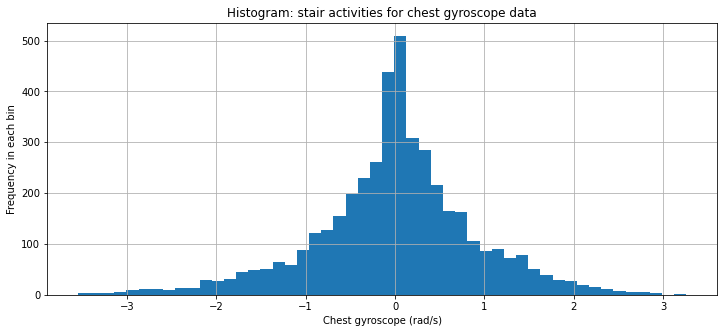

In [30]:
stairsdf.IMU_Chest_3D_gyroscope_2.hist(figsize=(12,5), bins=50)
plt.title('Histogram: stair activities for chest gyroscope data')
plt.xlabel('Chest gyroscope (rad/s)')
plt.ylabel('Frequency in each bin');

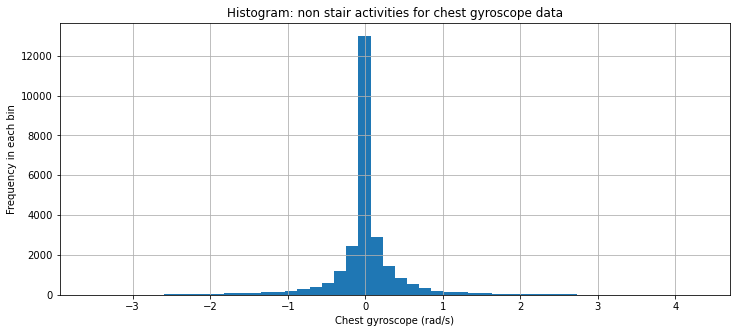

In [31]:
notstairsdf.IMU_Chest_3D_gyroscope_2.hist(figsize=(12,5), bins=50)
plt.title('Histogram: non stair activities for chest gyroscope data')
plt.xlabel('Chest gyroscope (rad/s)')
plt.ylabel('Frequency in each bin');

In [32]:
#Calculating the mean, standard deviation and count(the number of data points) for both the stair and non stair dfs
stairs_mean=stairsdf.IMU_Chest_3D_gyroscope_2.abs().mean()
stairs_std=stairsdf.IMU_Chest_3D_gyroscope_2.abs().std()
stairs_count=stairsdf.IMU_Chest_3D_gyroscope_2.abs().count()
not_stairs_mean=notstairsdf.IMU_Chest_3D_gyroscope_2.abs().mean()
not_stairs_std=notstairsdf.IMU_Chest_3D_gyroscope_2.abs().std()
not_stairs_count=notstairsdf.IMU_Chest_3D_gyroscope_2.abs().count()

#calculating the denominator for the z score
error=(((stairs_std**2)/stairs_count)+((not_stairs_std**2)/not_stairs_count))**0.5   
z=(stairs_mean-not_stairs_mean)/error #z score formula
p_value = (1-stats.norm.cdf(z)) #calulcating p value for normal distribution
print ('One tail high intesity activities compared to low intensity activites difference: ', p_value)

One tail high intesity activities compared to low intensity activites difference:  0.0


Our p-value is 0.0 which is less than our significance level of 0.1 therefore we can **accept our alternate hypothesis.** Our alternate hypothesis suggested that climbing or descending stairs was related to latitude change, we can now see that that is statistically accurate.

### 6.3 Temperature Hypothesis
**If** high temperature is related to high intensity activities **then** when intensive activities are performed mean temperature will be higher than those who are performing lower intensity activities.

Please refer to hypothesis 6.1 for explanation of 'high' and 'low' intensity activities.

$μ_1$ = Mean temperature for 'higher intensity activities'

$μ_2$ = Mean temperature for 'lower intensity activities'

**Null hypothesis:** higher intensity mean temperature rate minus lower intensity mean temperature is zero

>$H_0:μ_1-μ_2 = 0$ 

**Testable hypothesis:** higher intensity mean temperature minus lower intensity mean temperature is more than zero

>$H_1:μ_1-μ_2 > 0$ 

In [33]:
print('Mean temperature for higher intensity activities: ' + str(highintensity.IMU_Chest_Temp.mean()))
print('Mean temperature for lower intensity activities: '+ str(lowintensity.IMU_Chest_Temp.mean()))

Mean temperature for higher intensity activities: 35.82683625968061
Mean temperature for lower intensity activities: 36.18252078853232


In [34]:
#Calculating the mean, standard deviation and count(the number of data points) for both the stair and non stair dfs
hintensity_mean=highintensity['IMU_Chest_Temp'].mean()
hintensity_std=highintensity['IMU_Chest_Temp'].std()
hintensity_count=highintensity['IMU_Chest_Temp'].count()
lintensity_mean=lowintensity['IMU_Chest_Temp'].mean()
lintensity_std=lowintensity['IMU_Chest_Temp'].std()
lintensity_count=lowintensity['IMU_Chest_Temp'].count()

#calculating the denominator for the z score
error=(((lintensity_std**2)/lintensity_count)+((hintensity_std**2)/hintensity_count))**0.5   
z=(hintensity_mean-lintensity_mean)/error #z score formula
p_value = (1-stats.norm.cdf(z)) #calulcating p value for normal distribution
print ('One tail high intesity activities compared to low intensity activites difference: ', p_value)

One tail high intesity activities compared to low intensity activites difference:  1.0


Our p-value is 1.0 which is clearly more than our significance level of 0.1 therefore we can **reject our alternate hypothesis.** Our alternate hypothesis suggested that more intense activities lead to higher temperatures, we can now see that that is statistically inaccurate.

---
## 7. Principle Component Analysis <a name="PCA"></a>

Principle component analysis allows us to reduce the dimensionality of our data. This has many benefits, such as speeding up run time, greater efficiency for teaching models and allows us to the view data in lower dimensions as we cannot visualise anything in greater than 3 dimensions. 

Principle component analysis creates new variables for every dimension of the original data, however, each new variable is a mixture of the initial data, done in such a way that the new variables, which are what we call our principle components, have the majority, and most important information, in the first variable. So we have 31 variables (excluding timestamp, activity, activityID), therefore we will have 31 principle components, the analysis will try to put the most information in the first component.

**Step 1: Standarise the data**

We first need to standardise the data which means moving the center of the data to the origin of the graph. This means that range of each of our variables is now the same, therefore, each variable will contribute equally to the analysis. So for example our temperature data maxes out around 38, whereas heart rate frequently goes as high as 160 or more, therefore, if we did not standardise the data, then heart rate would be much more dominant than temperature leading to biased results. To do this we use the formula:
>$$value - mean\over\ standard\:deviation $$

In [35]:
#creating a function to plot our points so we dont have to repeat
def plot_points(data, name='Random Dataset', axis_eq=True):
    plt.scatter(data[:,0], data[:,1], marker='x', color='b')
    plt.title(name)
    plt.xlabel('principle component 1')
    plt.ylabel('principle component 2')
    if axis_eq == True:
        plt.axis('equal')

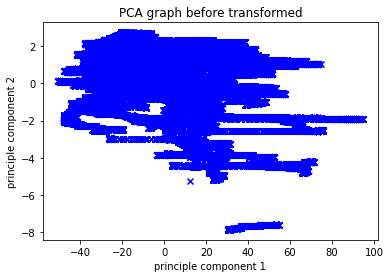

In [36]:
#new data frame with only the columns from heart rate to ankle magnetometer 3 included
df_1=df.loc[:,'Heartrate':'IMU_Ankle_3D_magnetometer_3'] 
data=df_1.to_numpy() #converts df to numpy array
data = data - data.mean(axis=0) #centering the data, by subtracting the mean of each column.

# Slice the data by taking x = first column, y = second column.
x = data[:, 0]
y = data[:, 1]
plot_points(data, name='PCA graph before transformed',axis_eq=False)

**Step 2: Covariance Matrix and corresponding eigenvalues** 

This step is done to see if any of the variable are closely related, as if they are producing very similar or the same data, then this can be made redundant. Referring back to our explanation for PCA we recall that we want to have the most information in our first component, so we use the variance to put variables with the largest variance in our first component. So when we order our eigenvalues from largest to smallest, we are also listing our principle components in order of significance.

In [37]:
Sigma = data.T.dot(data) #calculate covariance matrix
u, v = np.linalg.eig(Sigma) #calculate eigenvectors and eigenvalues
print('Eigenvalues are: {}'.format(u))
max_eigen_index = np.argsort(u)[-1] #ordered in ascending order, [-1] indexes the final element of the list
min_eigen_index = np.argsort(u)[0]
print('The largest eigenvalue is at index : {}'.format(max_eigen_index))

Eigenvalues are: [2.81407996e+08 1.71570871e+08 1.18122992e+08 7.55445322e+07
 6.79184950e+07 5.94124455e+07 4.14282052e+07 3.63890504e+07
 2.34454976e+07 1.73771822e+07 6.15257667e+06 5.02567680e+06
 4.02764363e+06 2.84762528e+06 1.89212079e+06 1.29083542e+06
 1.18349020e+06 9.55702857e+05 7.95151182e+05 7.39241206e+05
 4.23489733e+05 3.08042542e+05 2.25597536e+05 9.99468174e+03
 2.07359935e+04 3.87104282e+04 5.89619166e+04 9.14971332e+04
 1.40321684e+05 1.24955051e+05 1.12204951e+05]
The largest eigenvalue is at index : 0


**Step 3: Plot and Transform**

We now want to plot our principle components and use our eigenvalues to create arrows that represent our first two principle components on our graph, we have also rotated the graph so that the lines are at parallel to the axes.

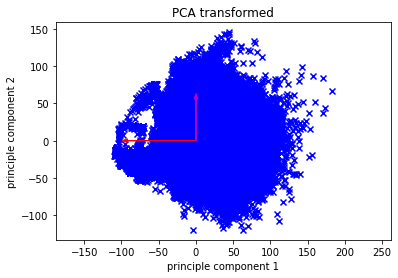

In [38]:
transformed = data.dot(v)#returns the dot product
plot_points(transformed, name='PCA transformed')
Sigma=transformed.T.dot(transformed)# covariance matrix
u1,v1=np.linalg.eig(Sigma) #eigenvalue and eigenvector
total=sum(u1) 
prop=[x/total for x in u1] #calculating the proportional arrow size multiplier

#plot proportional arrows
plt.arrow(0, 0, 300*prop[0]*v1[0,0], 300*prop[0]*v1[1,0] , color='r', head_width=5)
plt.arrow(0, 0, 300*prop[1]*v1[0,1],300*prop[1]*v1[1,1] , color='m', head_width=5);

It's currently unclear to see whether the PCA has been helpful so we need to view our graphs differently.

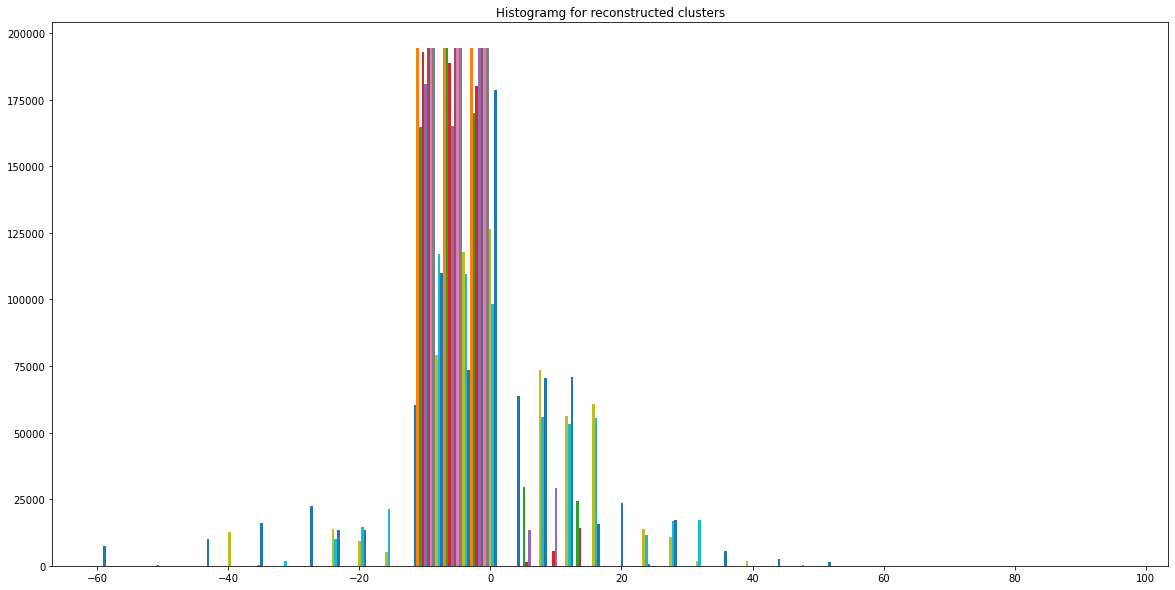

In [39]:
first_component = np.zeros((31,2)) #making an empty array the same size as the new data
first_component[:,max_eigen_index] = v[:,max_eigen_index] #putting all the eigen values in the empty array
reconstructed = data.dot(first_component.dot(first_component.T)) #dot product
plt.figure(figsize=(20,10)) #make the plot bigger
plt.hist(reconstructed) #plotting
plt.title('Histogramg for reconstructed clusters');

We can clearly see three peaks where our data is clustered.

---
## 8. Clustering <a name="clustering"></a>
Clustering is way of grouping data into 'clusters' where the data within each cluster is more closely related to each other. I will be using K-means clustering which is a partitional clustering algorithm, this means that there is a central vector for each cluster and the groups are formed based on how far they are from this point or 'centroid'.

K-means works by picking a specified number of centroids (based on how many clusters would seem to show the optimal arrangement, this can be calculated separately). Clusters are then formed based on whichever centroid the data points are closest to. Once these clusters are formed a new centroid is picked in the middle of the cluster and the process is repeated multiple times until the centroid no longer changes.

I used the 'elbow method' to try and pick the optimum number of clusters, this technique runs the K-Means model and varies the number of clusters from 1 to 10. For each version we are calculating the 'inertia' of the model, this is the sum of the squared distances between their closest cluster center. The idea with the elbow method is that each of these points is then plotted on the graph and the point where the graph bends most distinctly (ie the elbow) would be the best number of clusters. However, on my graph there is not a clear elbow so I have run my model with cluster sizes 2,3 and 4. 

When we produce our clusters we can gather data about how well our clusters have been formed, I have the ARI and the Silhouette score. 

The ARI (adjusted rand index) measures the similarity between clusters, the value of the ARI would be 0 if the values were randomly assigned to a cluster, therefore the closer an ARI is to 1, the better. 

The Silhouette score measures how dense or sparse clusters are, and looks at the distances between each cluster. The Silhouette score is between -1 and 1, a silhouette score close to 1 means the clusters are quite dense and clearly separated from the other clusters. A score of 0 means the clusters are fully overlapping each other, and anything less than one suggests an error has occurred in creating the clusters.

Therefore, we want both our ARI score and Silhouette score to be as close to 1 as possible.

In [40]:
Labels = df['Activity'] #creating our lables for our learning
#creating a new data frame with only the columns from heart rate to ankle magnetometer 3
Data = df.loc[:,'Heartrate':'IMU_Ankle_3D_magnetometer_3'] 
Labels_keys = Labels.unique().tolist() #converts data frame to list
Labels = np.array(Labels) #creates a Labels array
print('Activity labels: ' + str(Labels_keys))

Activity labels: ['rope jumping', 'lying', 'sitting', 'standing', 'ironing', 'vacuum cleaning', 'ascending stairs', 'descending stairs', 'walking', 'Nordic walking', 'cycling', 'running']


In [41]:
#normalise the data
scaler = StandardScaler()
Data = scaler.fit_transform(Data)

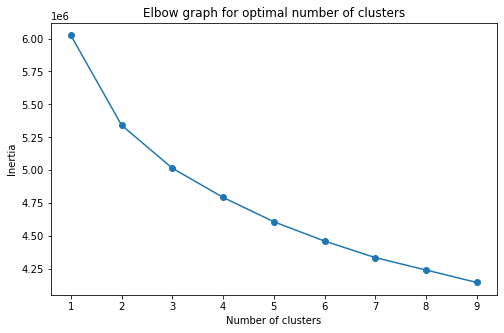

In [42]:
#check the optimal k value
clusters = range(1, 10) #check cluster sizes 1 to 10
inertias = [] #empty list for inertias to be added

for i in clusters: #loop through number of clusters
    model = KMeans(n_clusters=i).fit(Data) #set model = to KMeans for i number of clusters
    inertias.append(model.inertia_) #add model to the list of intertias

plt.figure(figsize=(8,5)) #make plot bigger
plt.plot(clusters, inertias, '-o') #plot the clusters on x and intertias on y with -o which means a line connecting dots
plt.title('Elbow graph for optimal number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(clusters)
plt.show()

In [43]:
def k_means(n_clust, data_frame, true_labels): #Function applies k-means clustering algorithm on dataset 
#running the KMeans Sklearn function for n_clust number of clusters, set random state to keep the same, 30 runs 
    k_means = KMeans(n_clusters = n_clust, random_state=123, n_init=30) 
    k_means.fit(data_frame) #train the model
    c_labels = k_means.labels_ #set culster labels
    df = pd.DataFrame({'Cluster': c_labels, 'Activity': true_labels.tolist()}) #new data frame with cluster labels and actual labels
    ct = pd.crosstab(df['Cluster'], df['Activity']) #crosstabulating culster and activity columns 
    y_clust = k_means.predict(data_frame) #predicts the labels
    display(ct)
    print('ARI = ' +str(round(adjusted_rand_score(true_labels, y_clust),2)))
    print('Silhouette Score = '+str(round(silhouette_score(data_frame, y_clust, metric='euclidean'),2)))

In [45]:
%%time 
#these sections take a long time to run so this is here to measure the time (around 15mins)
k_means(n_clust=2, data_frame=Data, true_labels=Labels) #running the KMeans function for 2 clusters

Activity,Nordic walking,ascending stairs,cycling,descending stairs,ironing,lying,rope jumping,running,sitting,standing,vacuum cleaning,walking
Cluster,,,,,,,,,,,,
0,0,0,0,10,0,17902,3,1,551,0,0,0
1,18819,11735,16466,10500,23871,1355,4937,9824,17956,18986,17543,23876


ARI = 0.04
Silhouette Score = 0.21
CPU times: user 12min 16s, sys: 2min 51s, total: 15min 8s
Wall time: 11min 55s


In [46]:
%%time 
#these sections take a long time to run so this is here to measure the time (around 15mins)
k_means(n_clust=3, data_frame=Data, true_labels=Labels) #running the KMeans function for 3 clusters

Activity,Nordic walking,ascending stairs,cycling,descending stairs,ironing,lying,rope jumping,running,sitting,standing,vacuum cleaning,walking
Cluster,,,,,,,,,,,,
0,12174,6818,13680,4050,37,990,4830,8307,495,1214,5208,12318
1,0,0,0,12,0,17486,1,0,7,0,0,0
2,6645,4917,2786,6448,23834,781,109,1518,18005,17772,12335,11558


ARI = 0.12
Silhouette Score = 0.14
CPU times: user 12min 7s, sys: 2min 42s, total: 14min 50s
Wall time: 11min 16s


In [47]:
%%time 
#these sections take a long time to run so this is here to measure the time (around 15mins)
k_means(n_clust=4, data_frame=Data, true_labels=Labels) #running the KMeans function for 4 clusters

Activity,Nordic walking,ascending stairs,cycling,descending stairs,ironing,lying,rope jumping,running,sitting,standing,vacuum cleaning,walking
Cluster,,,,,,,,,,,,
0,4577,3340,2631,5420,23796,851,72,496,18008,17665,11418,7066
1,5240,2132,381,2259,7,21,1163,3662,12,17,506,6841
2,9002,6263,13454,2822,68,902,3704,5666,484,1304,5619,9969
3,0,0,0,9,0,17483,1,1,3,0,0,0


ARI = 0.15
Silhouette Score = 0.13
CPU times: user 11min 44s, sys: 2min 46s, total: 14min 30s
Wall time: 10min 52s


None of our clusters are very promising based on the scores we have seen however we will still visualise them below.

Using 3 clusters as this is the best balance of silhouette score and ARI.

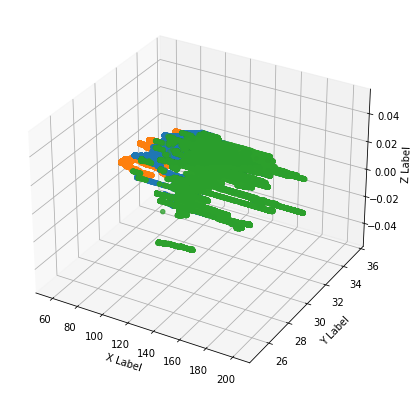

In [48]:
K=3 #number of clusters

df_1=df.loc[:,'Heartrate':'IMU_Ankle_3D_magnetometer_3'] #create new dataframe for columns heart rate to ankle 3d magnetommeter
data=df_1.to_numpy() #converts df to numpy array

cl_K3=cluster.KMeans(init='k-means++',n_clusters=K) #runs Kmeans function, k-means++ speeds up convergence
cl_K3.fit(data) #training the model
cl_K3.predict(data) #predicting the labels

#To plot the clusters we need the co-ordinates of the points to be put in to lists
def divide(data,labels):
    xclusters=defaultdict(list)
    yclusters=defaultdict(list)
    for datapoint,label in zip(data,labels):
        x=datapoint[0]
        y=datapoint[1]
        xclusters[label].append(x)
        yclusters[label].append(y)
    return xclusters,yclusters    


clusters=divide(data,cl_K3.predict(data)) # apply the function that makes the data point lists to the predicted 

#plotting 3d graph
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(clusters[0][0],clusters[1][0])
ax.scatter(clusters[0][1],clusters[1][1])
ax.scatter(clusters[0][2],clusters[1][2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

---
## 9. Logistical Regression <a name="logreg"></a>

Logistical regression is a form of supervised learning, it is a classification algorithm. It uses probabilities as a predictive analysis algorithm.

We first scale our data, but we only need to include our actual data points so I have removed our downsampled timestamps, normal timestamps, subjects and activity names, as these columns do not need to be analysed. We then separate out our ActivityID column as this is supervised learning we are using the activities as our labels.

In [49]:
#apply scaling to all columns except subject and activity 
scaler = RobustScaler()
dfd_scale = dfd.copy()
df_test_scale = testdf.copy()

dfd_scale=dfd_scale.drop(["DStime","Timestamp","subject","Activity"],axis=1)
df_test_scale=df_test_scale.drop(["DStime","Timestamp", "subject","Activity"],axis=1)

dfd_scale.iloc[:,1:32] = scaler.fit_transform(dfd_scale.iloc[:,1:32])
df_test_scale.iloc[:,1:32] = scaler.fit_transform(df_test_scale.iloc[:,1:32])

#development set scaling one set without activityID labels and one set with only the labels
xd = dfd_scale.drop('ActivityID', axis=1).values
yd = dfd_scale['ActivityID'].values

# test set scaling one set without activityID labels and one set with only the labels
xt = dfd_scale.drop('ActivityID', axis=1).values
yt = dfd_scale['ActivityID'].values

dfd_scale.head()

,ActivityID,Heartrate,IMU_Hand_Temp,IMU_Hand_3D_acceleration_1,IMU_Hand_3D_acceleration_2,IMU_Hand_3D_acceleration_3,IMU_Hand_3D_gyroscope_1,IMU_Hand_3D_gyroscope_2,IMU_Hand_3D_gyroscope_3,IMU_Hand_3D_magnetometer_1,...,IMU_Ankle_Temp,IMU_Ankle_3D_acceleration_1,IMU_Ankle_3D_acceleration_2,IMU_Ankle_3D_acceleration_3,IMU_Ankle_3D_gyroscope_1,IMU_Ankle_3D_gyroscope_2,IMU_Ankle_3D_gyroscope_3,IMU_Ankle_3D_magnetometer_1,IMU_Ankle_3D_magnetometer_2,IMU_Ankle_3D_magnetometer_3
25199,2,-1.052632,-0.605263,0.470480,0.554536,0.689585,-0.005031,-0.019849,-0.004661,-0.453618,...,-1.791667,-0.217304,-0.284657,-0.465174,0.022438,-0.045475,0.007732,1.223394,-0.262174,-0.261265
65155,17,0.052632,0.157895,-0.002152,-0.831132,0.758345,2.789745,-0.495979,-0.290999,1.087985,...,0.083333,0.334359,0.167232,0.937417,0.068019,2.412273,0.383805,-0.204757,-0.162542,0.765297
93827,16,-0.315789,0.026316,-0.442869,0.594210,-0.562290,0.002658,-2.401127,-0.858714,0.211252,...,0.041667,0.880307,0.253775,0.441544,1.110999,-2.743347,0.736954,-0.258967,-0.651796,0.249234
116699,12,1.631579,0.342105,-0.647361,-1.138530,-0.839191,0.384836,-0.938393,-1.472704,0.283390,...,-0.125000,0.476694,-0.014671,-0.303762,-1.329246,2.342571,2.122575,-0.119282,0.209661,0.159240
174788,7,0.289474,-1.052632,1.021523,2.088703,0.053805,1.150067,-0.226268,-1.308977,-1.205259,...,0.125000,5.981874,0.435914,2.656447,0.459407,1.584956,-4.684321,0.458803,1.077206,0.183923


Now that we have scaled our data we can run out analysis and 

In [51]:
logreg = LogisticRegression() #setting Sklearn logistic regression function to shorter variable 'logreg'
logreg.fit(X=xd, y=yd) #training the model based on our scaled development set
y_pred_lr = logreg.predict(xt) #then using our test set to predict

#calculating precision, recall and F1 score to see how the regression is performing
def get_metrics (actual,prediction):
    prec = precision_score(actual, prediction,average=None).mean()
    rec = recall_score(actual, prediction, average=None).mean()
    f1 = f1_score(actual, prediction, average=None).mean()
    print("Precision score: "+ str(round(prec,3)))
    print("Recall score: "+ str(round(rec,3)))
    print("F1 score: "+ str(round(f1,3)))
    
get_metrics(yt, y_pred_lr)

/Users/leila/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision score: 0.812
Recall score: 0.8
F1 score: 0.805


**Precision score** is between 0 and 1 and uses the formula $$true\:positive\over\ predictive\:positives$$ so we want our value of 0.812 is close to 1 which suggests good precision

**Recall score** is between 0 and 1 and uses the formula $$true\:positive\over\ actual\:positives$$ so we also want this value of 0.8 is close to 1 which suggests 

**F1 score** is between 0 and 1 and uses the formula $$2 * precision*recall\over\ precision + recall$$ so we also want this value to be close to 1.

---
## 10. Recommendations and Summary <a name="recs"></a>

### 10.1 Recommendations

Based all of the evidence gathered from my report I would make three key recommendations to aid the development of hardware of software that could analyse the amount of exercise a user has performed.

1. **If their heart rate is over 120 BPM for an extended period (over a minute), then they are most likely performing a high intensity activity.** The level of 120 BPM is based off the levels seen in my exploratory data analysis and hypothesis testing. In my first hypothesis test we also found it to be statistically accurate that higher intensity activities lead to higher heart rates.

2. **If their chest 3D gyroscope data 2 is greater than 0.35 or less than 0.35 then they are most likely climbing or descending stairs, respectively.** 0.35 has been specified from looking at our exploratory data analysis and our hypothesis tests, for example the average chest gyroscope data for people using stairs was 0.65 compared to 0.25 for those who were not. In our hypothesis test we showed that people who were using stairs have a statistically significant difference in their 3D gyroscope data, where those using stairs was higher. The data used in that test was absolute so that the negative number for people going down stairs did not cancel out the data.

3. **Temperature does not correlate to activity so this should not be used as a parameter** Before analysing my data I had the (incorrect) preconceived notion that increased activity would lead to increased temperature, however as seen in my third hypothesis test, this is inaccurate and therefore should not be used a method to measure activity.


### 10.2 Summary of Specific Requirements

Going back to the specific requirements of the report I will review what I have done for each requirement and the overall summary of the report.

#### <u>Carry out thorough exploratory data analysis and appropriately handle missing or dirty data:</u>
In section 2 I cleaned a filtered my data but removing all invalid data that was noted in the readme file:
- any rows where activity number is 0 
- the 6g acceleration columns as they were not precisely calibrated
- all orientation columns as the data was invalid
I also cleaned the data by removing all Nan files, but only after I had filled in the gaps in the heart rate data as that was only ~9Hz whereas the rest of the data was 100Hz, which meant there were lots of NaN values in the heart rate column.

Some of the activities were optional which lead to less participants such as car driving and watching TV that only have one participant and playing soccer only has two. For that reason I will also be removing all of the optional activities.

For my **EDA** I looked at three different key variables, **heart rate, temperature, and chest gyroscope** and I also created a heat map to show the correlation between all of the variables.

When looking at heart rate I created a bar chart for each activity, but to see a bit more detail I made a box plot of all of the data and sorted it by median heart rate with a superimposed line for the mean heart rate of the data to show which activities were higher or lower.
    
Analysing the temperature data I created a box plot that combined all of the three temperature data points we had into one, it showed that chest data was the highest but also closet to the users actual temperature rather than their surrounds which I why I used chest temperature for my hypothesis test.
    
Observing the chest gyroscope data it was clear to see on the bar chart that stair related activities were standing out in opposite directions for climbing and going down stairs. 


#### <u> Develop and test at least one hypothesis for a relationship between a single pair of attributes: </u>
Here are the three hypothesis tests I ran and their corresponding results:

>**If** higher intensity activities are related to heart rate, **then** when intensive activities are performed heart rate will be higher than those who are performing lower intensity activities.
We **<font color='green'>accept</font>** the alternate hypothesis.

>**If** stair ascending or descending activities are related to latitude change, **then** when stair activities are performed chest gyroscope 2 will have a higher absolute mean value.
We **<font color='green'>accept</font>** the alternate hypothesis.

>**If** high temperature is related to high intensity activities **then** when intensive activities are performed mean temperature will be higher than those who are performing lower intensity activities.
We **<font color='red'>reject</font>** the alternate hypothesis.

#### <u> Develop and test at least one model which uses multiple attributes to make predictions: </u>
I created two model, cluster analysis and logistical regression.

For details on how the models work please see the respective sections, here I will take about the results of training those models.

For my clustering model, I created a graph to find the optimum number of clusters however the results where unclear so I decided to run the models with 2,3 and 4 clusters to see the silhouette and ARI score. Once running those models the scores for each one was not very promising with the highest silhouette score being 0.21 and the highest ARI at 0.15 this would suggest there are not clear clusters in the data. If I had more resources I would try to create the cluster model again but with a stronger emphasis on the heart rate as I think the number of other variables out weighed how important this variable is.

My logistical regression model, however, had some much more promising results after training the model when testing the values where much more positive with an F1 score of 0.805 - where the F1 score is from 0 to 1 and measures the model's accuracy on the dataset.


#### Word Count

In [52]:
import io
from IPython.nbformat import current

with io.open('Report 2.ipynb', 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        
        word_count += len(cell['source'].replace('# ', '').lstrip().split(' '))
print('Word Count: '+ str(word_count))

/Users/leila/opt/anaconda3/lib/python3.8/site-packages/IPython/nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "
/Users/leila/opt/anaconda3/lib/python3.8/site-packages/nbformat/current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.


Word Count: 4157


## References
---
Medium. 2022. Note to Self: Pandas Sort Boxplots by Median. [online] Available at: <https://medium.com/the-barometer/note-to-self-pandas-sort-boxplots-by-median-2a6c70c11644>

Mayo Clinic. 2022. 2 easy, accurate ways to measure your heart rate. [online] Available at: <https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979#:~:text=A%20normal%20resting%20heart%20rate%20for%20adults%20ranges%20from%2060,to%2040%20beats%20per%20minute> 

Matplotlib.org. 2022. Choosing Colormaps in Matplotlib — Matplotlib 3.5.1 documentation. [online] Available at: <https://matplotlib.org/stable/tutorials/colors/colormaps.html>

Kaggle.com. 2022. K-Means Clustering + PCA. [online] Available at: <https://www.kaggle.com/ruslankl/k-means-clustering-pca>

Built In. 2022. A Step-by-Step Explanation of Principal Component Analysis (PCA). [online] Available at: <https://builtin.com/data-science/step-step-explanation-principal-component-analysis>

Styles, Vanessa; Lab 6 Solutions Exercise 1

Styles, Vanessa; Lab 7 Solutions Exercise 0.1,0.2